***************************************************************************************/
*    Title: LSTM Ubuntu Chatbot 
*    Author: Kate Mortensen 
*    Date: 12-11-2021
*    Code version: 1.0
*    Availability: NA
*    
* @article{lowe2015ubuntu,
*  title={The ubuntu dialogue corpus: A large dataset for research in unstructured multi-turn dialogue systems},
*  author={Lowe, Ryan and Pow, Nissan and Serban, Iulian and Pineau, Joelle},
*  journal={arXiv preprint arXiv:1506.08909},
*  year={2015}
*  }
* @article{kadlec2015improved,
*  title={Improved deep learning baselines for ubuntu corpus dialogs},
*  author={Kadlec, Rudolf and Schmid, Martin and Kleindienst, Jan},
*  journal={arXiv preprint arXiv:1510.03753},
*  year={2015}
*  }
* Code Inspiration
* Author: Janina Nuber
* Tile: Chatbot | Retrieval-based Dialog System on the Ubuntu Dialog Corpus | LSTM | PyTorch
* Date: July 31st, 2019
* Availability: https://github.com/Janinanu/Retrieval-based_Chatbot
*
***************************************************************************************/

# PART 1 

**Purpose:**
*The purpose of this project’s chatbot, named Chatty Kathy, is to provide technical support to Ubuntu users. Chatbots often sustain the reputation of being robotic and there is ongoing work to improve the human-like quality of responses. Retrieval-based chatbots rely on a set predefined responses to a user’s input question. There are many ways to choose the best response based on a document of input questions and responses. For example, some retrieval based chatbots produce responses based on “intent” via Tf-idf or BOW while others are based on “entity” and use POS tagging or various word embedding methods. Chatty Kathy is a very simple implementation of a retrieval-based chatbot and is judged using Ubuntu Dialog Corpus as a standard. An LSTM model is used to test whether Chatty Kathy’s responses are sufficiently human based training data from the Ubuntu Dialog Corpus.*

**Data:**
*The Ubuntu Dialog Corpus and Ubuntu Dialog Helpchat were used for this project (Lowe 2016). The Ubuntu Dialog Helpchat data was used to produce responses from Chatty Kathy while the Ubuntu Dialog Corpus was uses to train the LSTM model for retrieval-based chatbots. The Ubuntu Dialog Corpus consists of ~1 million bidirectional conversations from internal Ubuntu chat rooms, providing a substantial amount of data. The Ubuntu Dialog Helpchat data underwent data processing steps as part of the chatbot. The Ubuntu Dialog Corpus came processed and labeled (Nuber 2019). The data format is comma separated for both raw and LSTM ready data. The LSTM data and has 3 columns (user input, bot response, 1=true response/0=random response).*

**Setup**

In [130]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Data Pre-processing Libraries 
import warnings
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import spacy
from spacy import displacy
import en_core_web_sm
# Feature Extraction Libraries
import collections
from collections import Counter
import en_core_web_sm
from nltk.probability import FreqDist 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# Training
import torch.nn as nn
import torch
import torch.autograd as autograd
from torch.nn import init
import torch.nn.utils.rnn 
import datetime
import operator

warnings.filterwarnings('ignore')
np.random.seed(0)


# PART 2

### Data Processing

In this section, the raw dialogue text from the Ubuntu Help 
Chat data set was analyzed and pre-processed. 

**Quick Exploratory Analysis**

In [131]:
def quick_analysis(path) :
    df = pd.read_csv(path)
    print("How many samples/rows in the dataset? ", len(df.index))
    print("Are there any empty entries?", df['text'].empty==True)
    print("How many empty rows (e.g. missing text entries)? ",len(df[(df['text'].isnull==True) or (df['text']=="")]) )
    print("Sample of text: ", df['text'][0])

quick_analysis("./Ubuntu-dialogue-corpus/dialogueText.csv")

How many samples/rows in the dataset?  1038324
Are there any empty entries? False
How many empty rows (e.g. missing text entries)?  0
Sample of text:  Hello folks, please help me a bit with the following sentence: 'Order here your personal photos or videos.' - I think the only allowed version is 'Order your personal videos or photos here.', but I'm not sure, are you?


**Sentence Tokenization**

In [132]:
# Pass your text into sentence tokenizer. You can specify a language parameter, for example language = "english"
df = pd.read_csv("./dialogueText.csv")
text = df['text'][0]
tokenized_text=sent_tokenize(text)
print("Tokenized text: ")
print(tokenized_text)

Tokenized text: 
["Hello folks, please help me a bit with the following sentence: 'Order here your personal photos or videos.'", "- I think the only allowed version is 'Order your personal videos or photos here.", "', but I'm not sure, are you?"]


**Word Tokenization**

In [133]:
tokenized_word=word_tokenize(text) 
print("Tokenized Word: ")
print(tokenized_word)

Tokenized Word: 
['Hello', 'folks', ',', 'please', 'help', 'me', 'a', 'bit', 'with', 'the', 'following', 'sentence', ':', "'Order", 'here', 'your', 'personal', 'photos', 'or', 'videos', '.', "'", '-', 'I', 'think', 'the', 'only', 'allowed', 'version', 'is', "'Order", 'your', 'personal', 'videos', 'or', 'photos', 'here', '.', "'", ',', 'but', 'I', "'m", 'not', 'sure', ',', 'are', 'you', '?']


**Quick Post Tokenization Analysis**

In [134]:
all_text = [i for i in df['text']]
all_sentences = sent_tokenize(text=str(all_text))
print('Total sentences in dataset:', len(all_sentences))
tokens_sentences = [word_tokenize(t) for t in sent_tokenize(str(all_text))]
words = [word for sentence in tokens_sentences for word in sentence]
# length of sentences
sent_lengths = [len(s) for s in tokens_sentences]
print('Average sentence length: ', sum(sent_lengths)/len(sent_lengths))
# length of words
word_lengths = [len(word) for word in words]
print("Average word length: ", sum(word_lengths)/len(word_lengths))

Total sentences in dataset: 626009
Average sentence length:  24.19789172360142
Average word length:  3.5200949980651037


**Lexical Diversity Method**

In [135]:
# Resource: https://python-forum.io/thread-12570.html
def lexical_diversity(text):
    return len(text) / len(set(text))
 
def percentage(count, total):
    return 100 * count / total

print("lexical diversity")
print("")
for cat in words[0:5] :
#for cat in nltk.corpus.brown.categories():
    print(cat, ": ", lexical_diversity(cat))

lexical diversity

[ :  1.0
`` :  2.0
Hello :  1.25
folks :  1.0
, :  1.0


**Word Frequency & Plot Tokens**

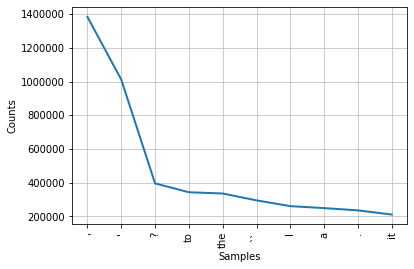

In [136]:
fdist = FreqDist(words)
fdist.plot(10,cumulative=False)
plt.show()

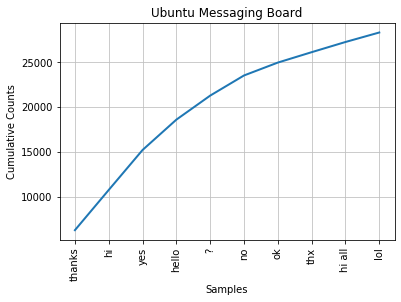

In [137]:
fdist = nltk.FreqDist(all_text)
fdist.plot(10, cumulative=True, title="Ubuntu Messaging Board")

**Formatting**

In [138]:
# Lowercase & Runctuation
words = [word.lower() for word in words if word.isalpha()]
stop_words = stopwords.words('english')
filtered_words = [w for w in words if not w in stop_words] 
# Add stop words
custom_list = ['like','would','could','said','one']
stop_words.extend(custom_list)
# Remove stop words
stop_words = list(set(stopwords.words('english')) - set(['again', 'once', 'from']))

**Count Common Words**

In [139]:
word_counts = collections.Counter(words)
word_counts.most_common(5)

[('i', 454092), ('to', 343862), ('the', 340437), ('a', 250718), ('it', 219521)]

**Stemmer**

In [140]:
ps = PorterStemmer()
stemmed = [ps.stem(word) for word in words]

**Lemmatize**

In [141]:
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(w) for w in filtered_words]
print(lemmatized[0:10])

['hello', 'folk', 'please', 'help', 'bit', 'following', 'sentence', 'personal', 'photo', 'video']


**NER**

In [142]:
nlp = en_core_web_sm.load()
doc = nlp(str(df['text'][54:64]))
print([(X.text, X.label_) for X in doc.ents])

[('54', 'CARDINAL'), ('55', 'CARDINAL'), ('56', 'CARDINAL'), ('57', 'CARDINAL'), ('58', 'CARDINAL'), ('59', 'CARDINAL'), ('60', 'CARDINAL'), ('Deskyop', 'PERSON'), ('61', 'CARDINAL'), ('62', 'CARDINAL'), ('63', 'CARDINAL'), ('NFS', 'ORG')]


**Text Preprocessing & Cleaning**

In [143]:
corpus = np.array(all_text)
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

# The following normalization method is sufficient - chat conversations are simple lines of text and don't need further processing.
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)
# must create a sample of normalized corpus - data too much for RAM
sample_norm_corpus = norm_corpus[0:20]


**Feature Extraction**

In [144]:

# get bag of words features in sparse format
cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(sample_norm_corpus) 
#cv_matrix = cv.fit_transform(norm_corpus) 

# view dense representation 
# warning might give a memory error if data is too big
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# show document feature vectors
m1 = pd.DataFrame(cv_matrix, columns=vocab)
print("Length of normalized corpus sample: ", len(vocab))


Length of normalized corpus sample:  93


**TFid Transformer**

In [145]:
tt = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tt_matrix = tt.fit_transform(cv_matrix)

tt_matrix = tt_matrix.toarray()
vocab = cv.get_feature_names()

In [146]:
tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
                     use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(sample_norm_corpus)
#tv_matrix = tv.fit_transform(norm_corpus)

tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
m2 = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)

# PART 3 

***************************************************************************************/
* Code Inspiration
* Author: Janina Nuber
* Tile: Chatbot | Retrieval-based Dialog System on the Ubuntu Dialog Corpus | LSTM | PyTorch
* Date: July 31st, 2019
* Availability: https://github.com/Janinanu/Retrieval-based_Chatbot
*
***************************************************************************************/

**Helper Functions for Training & Validation**

In [147]:
# Creates pandas dataframe from csv file
def create_dataframe(csvfile): 
    dataframe = pd.read_csv(csvfile)
    return dataframe
# Shuffles idices in df (always a good practice in ML)
def shuffle_dataframe(dataframe):
    dataframe.reindex(np.random.permutation(dataframe.index))
# Create vocab list from user chats and bot responses
def create_vocab(dataframe):
    vocab = []
    word_freq = {}
    
    for index, row in dataframe.iterrows():
        
        context_cell = row["Context"]
        response_cell = row["Utterance"]
        
        train_words = str(context_cell).split() + str(response_cell).split()
        
        for word in train_words:
            # potentiallly more efficient to use "set" 
            if word.lower() not in vocab:
                vocab.append(word.lower())         
                       
            if word.lower() not in word_freq:
                word_freq[word.lower()] = 1
            else:
                word_freq[word] += 1
    
    word_freq_sorted = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    vocab = ["<UNK>"] + [pair[0] for pair in word_freq_sorted]
    
    return vocab


def create_word_to_id(vocab):             
    word_to_id = {word: id for id, word in enumerate(vocab)}
    
    return word_to_id


def create_id_to_vec(word_to_id, glovefile): 
    lines = open(glovefile, 'r').readlines()
    id_to_vec = {}
    vector = None
    
    for line in lines:
        word = line.split()[0]
        vector = np.array(line.split()[1:], dtype='float32') #32
        
        if word in word_to_id:
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(vector))
            
    for word, id in word_to_id.items(): 
        if word_to_id[word] not in id_to_vec:
            v = np.zeros(*vector.shape, dtype='float32')
            v[:] = np.random.randn(*v.shape)*0.01
            id_to_vec[word_to_id[word]] = torch.FloatTensor(torch.from_numpy(v))
            
    embedding_dim = id_to_vec[0].shape[0]
    
    return id_to_vec, embedding_dim


def load_ids_and_labels(row, word_to_id):
    context_ids = []
    response_ids = []

    context_cell = row['Context']
    response_cell = row['Utterance']
    label_cell = row['Label']
    # potentially make max_context_len into function input var
    max_context_len = 160
    
    context_words = context_cell.split()
    if len(context_words) > max_context_len:
        context_words = context_words[:max_context_len]
    for word in context_words:
        if word in word_to_id:
            context_ids.append(word_to_id[word])
        else: 
            context_ids.append(0) #UNK
    
    response_words = response_cell.split()
    for word in response_words:
        if word in word_to_id:
            response_ids.append(word_to_id[word])
        else: 
            response_ids.append(0)
    
    label = np.array(label_cell).astype(np.float32)

    return context_ids, response_ids, label

def increase_count(correct_count, score, label):
    if ((score.data[0][0] >= 0.5) and (label.data[0][0] == 1.0)) or ((score.data[0][0] < 0.5) and (label.data[0][0]  == 0.0)):
       correct_count +=1  
   
    return correct_count

def get_accuracy(correct_count, dataframe):
    accuracy = correct_count/(len(dataframe))
        
    return accuracy


**Model Class Definitions**
*Note: Adjustments to the original script were made due to PyTorch version differences - specifically the way in which the tensor is accessed. In addition, the author notes that the models defined below include an additional dropout layer while the in-built dropout was set to 0.0. This was done because in the case where the num_layers=1, the in-built layer, by definition, is not applied to the last layer. The author provides two links for reference of this situation: http://pytorch.org/docs/master/nn.html#torch.nn.LSTM and https://discuss.pytorch.org/t/dropout-in-lstm/7784*


In [148]:
class Encoder(nn.Module):

    def __init__(self, 
            emb_size, 
            hidden_size, 
            vocab_size, 
            p_dropout): 
    
            super(Encoder, self).__init__()
             
            self.emb_size = emb_size
            self.hidden_size = hidden_size
            self.vocab_size = vocab_size
            self.p_dropout = p_dropout
       
            self.embedding = nn.Embedding(self.vocab_size, self.emb_size)
            self.lstm = nn.LSTM(self.emb_size, self.hidden_size)
            self.dropout_layer = nn.Dropout(self.p_dropout) 

            self.init_weights()
             
    def init_weights(self):
        init.uniform(self.lstm.weight_ih_l0, a = -0.01, b = 0.01)
        init.orthogonal(self.lstm.weight_hh_l0)
        self.lstm.weight_ih_l0.requires_grad = True
        self.lstm.weight_hh_l0.requires_grad = True
        
        embedding_weights = torch.FloatTensor(self.vocab_size, self.emb_size)
            
        for id, vec in id_to_vec.items():
            embedding_weights[id] = vec
        
        self.embedding.weight = nn.Parameter(embedding_weights, requires_grad = True)
            
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        _, (last_hidden, _) = self.lstm(embeddings) #dimensions: (num_layers * num_directions x batch_size x hidden_size)
        last_hidden = self.dropout_layer(last_hidden[-1])#access last lstm layer, dimensions: (batch_size x hidden_size)

        return last_hidden

    
class DualEncoder(nn.Module):
     
    def __init__(self, encoder):
        super(DualEncoder, self).__init__()
        self.encoder = encoder
        self.hidden_size = self.encoder.hidden_size
        M = torch.FloatTensor(self.hidden_size, self.hidden_size)     
        init.xavier_normal(M)
        self.M = nn.Parameter(M, requires_grad = True)

    def forward(self, context_tensor, response_tensor):
        
        context_last_hidden = self.encoder(context_tensor) #dimensions: (batch_size x hidden_size)
        response_last_hidden = self.encoder(response_tensor) #dimensions: (batch_size x hidden_size)
        
        #context = context_last_hidden.mm(self.M).cuda()
        context = context_last_hidden.mm(self.M) #dimensions: (batch_size x hidden_size)
        context = context.view(-1, 1, self.hidden_size) #dimensions: (batch_size x 1 x hidden_size)
        
        response = response_last_hidden.view(-1, self.hidden_size, 1) #dimensions: (batch_size x hidden_size x 1)
        
        #score = torch.bmm(context, response).view(-1, 1).cuda()
        score = torch.bmm(context, response).view(-1, 1) #dimensions: (batch_size x 1 x 1) and lastly --> (batch_size x 1)

        return score
    

**Create Variables via Predefined Helper Functions**
*Note: This method calls on previously defined helper functions. The desired number of examples and embedding dimensions are defined by the input arguments. Pre-trained embedding vectors were taken from GloVe file provided by author.*

In [149]:
def creating_variables(num_training_examples, num_validation_examples, embedding_dim):
    
    print(str(datetime.datetime.now()).split('.')[0], "Creating variables for training and validation...")

    training_dataframe = create_dataframe('training_%d.csv' %num_training_examples)
    vocab = create_vocab(training_dataframe)
    word_to_id = create_word_to_id(vocab)
    id_to_vec, emb_dim = create_id_to_vec(word_to_id, 'glove.6B.%dd.txt' %embedding_dim)

    validation_dataframe = create_dataframe('validation_%d.csv' %num_validation_examples)

    print(str(datetime.datetime.now()).split('.')[0], "Variables created.\n")
    
    return training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe

**Function to Create Model Instance & Set Hyperparameters**

In [150]:
def creating_model(hidden_size, p_dropout):
    
    print(str(datetime.datetime.now()).split('.')[0], "Calling model...")

    encoder = Encoder(
            emb_size = emb_dim,
            hidden_size = hidden_size,
            vocab_size = len(vocab),
            p_dropout = p_dropout)

    dual_encoder = DualEncoder(encoder)

    print(str(datetime.datetime.now()).split('.')[0], "Model created.\n")
    print(dual_encoder)
    
    return encoder, dual_encoder

**Function for Training & Validation**

In [169]:
def train_model(learning_rate, l2_penalty, epochs): 
    print(str(datetime.datetime.now()).split('.')[0], "Starting training and validation...\n")
    print("====================Data and Hyperparameter Overview====================\n")
    print("Number of training examples: %d, Number of validation examples: %d" %(len(training_dataframe), len(validation_dataframe)))
    print("Learning rate: %.5f, Embedding Dimension: %d, Hidden Size: %d, Dropout: %.2f, L2:%.10f\n" %(learning_rate, emb_dim, encoder.hidden_size, encoder.p_dropout, l2_penalty))
    print("================================Results...==============================\n")

    optimizer = torch.optim.Adam(dual_encoder.parameters(), lr = learning_rate, weight_decay = l2_penalty)
    loss_func = torch.nn.BCEWithLogitsLoss()
    #loss_func.cuda()
    best_validation_accuracy = 0.0
    
    counter = 0
    for epoch in range(epochs): 
            counter += 1

            shuffle_dataframe(training_dataframe)
            sum_loss_training = 0.0
            training_correct_count = 0
            dual_encoder.train()

            for index, row in training_dataframe.iterrows():            
            
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1), requires_grad = False) #.cuda()
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1), requires_grad = False) #.cuda()
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1))), requires_grad = False) #.cuda()
                             
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                #sum_loss_training += loss.data[0]
                sum_loss_training += loss.data
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                training_correct_count = increase_count(training_correct_count, score, label)
                                                    
            training_accuracy = get_accuracy(training_correct_count, training_dataframe)
            #plt.plot(epoch, training_accuracy)
                
            shuffle_dataframe(validation_dataframe)
            
            validation_correct_count = 0
            sum_loss_validation = 0.0
            dual_encoder.eval()

            for index, row in validation_dataframe.iterrows():
                
                context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
                context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)) #.cuda()
                response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)) #.cuda()
                label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))) #.cuda()
                
                score = dual_encoder(context, response)
                loss = loss_func(score, label)
                #sum_loss_validation += loss.data[0]
                sum_loss_validation += loss.data
                validation_correct_count = increase_count(validation_correct_count, score, label)
                    
            validation_accuracy = get_accuracy(validation_correct_count, validation_dataframe)

            if counter-1 == range(epoch) :           
                print(str(datetime.datetime.now()).split('.')[0], 
                    "Epoch: %d/%d" %(epoch,epochs),  
                    "TrainLoss: %.3f" %(sum_loss_training/len(training_dataframe)), 
                    "TrainAccuracy: %.3f" %(training_accuracy), 
                    "ValLoss: %.3f" %(sum_loss_validation/len(validation_dataframe)), 
                    "ValAccuracy: %.3f" %(validation_accuracy))
                
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                torch.save(dual_encoder.state_dict(), 'saved_model_%d_examples.pt' %(len(training_dataframe)))
                print("New best found and saved.")
              
    print(str(datetime.datetime.now()).split('.')[0], "Training and validation epochs finished.")


**Create Variables for Training & Validation**

In [170]:
training_dataframe, vocab, word_to_id, id_to_vec, emb_dim, validation_dataframe = creating_variables(num_training_examples = 1000, 
                                                                                                     embedding_dim = 50, 
                                                                                                     num_validation_examples = 100)

2021-12-12 20:37:26 Creating variables for training and validation...
2021-12-12 20:37:35 Variables created.



**Create Model**

In [171]:
encoder, dual_encoder = creating_model(hidden_size = 50, 
                                       p_dropout = 0.85)

#encoder.cuda()
#dual_encoder.cuda

for name, param in dual_encoder.named_parameters():
    if param.requires_grad:
        print(name)

2021-12-12 20:37:35 Calling model...
2021-12-12 20:37:35 Model created.

DualEncoder(
  (encoder): Encoder(
    (embedding): Embedding(6885, 50)
    (lstm): LSTM(50, 50)
    (dropout_layer): Dropout(p=0.85, inplace=False)
  )
)
M
encoder.embedding.weight
encoder.lstm.weight_ih_l0
encoder.lstm.weight_hh_l0
encoder.lstm.bias_ih_l0
encoder.lstm.bias_hh_l0


**Train Model**

In [168]:
train_model(learning_rate = 0.0001, 
            l2_penalty = 0.0001,
            #epochs = 100)
            epochs = 10)

2021-12-12 20:32:24 Starting training and validation...

====================Data and Hyperparameter Overview====================

Number of training examples: 1000, Number of validation examples: 100
Learning rate: 0.00010, Embedding Dimension: 50, Hidden Size: 50, Dropout: 0.85, L2:0.0001000000

================================Results...==============================

New best found and saved.
2021-12-12 20:37:26 Training and validation epochs finished.


# PART 4

**Load Testing Models**

In [172]:
dual_encoder.load_state_dict(torch.load('./saved_model_1000_examples.pt'))
dual_encoder.eval()

DualEncoder(
  (encoder): Encoder(
    (embedding): Embedding(6885, 50)
    (lstm): LSTM(50, 50)
    (dropout_layer): Dropout(p=0.85, inplace=False)
  )
)

**Test Approach**

*This testing approach assumes the data is formatted in the same way as the training and validation data. For example, each line in the csv file contains user input (aka context), bot response, and label (separated with commas). The testing metric used in this approach is Accuracy.*

In [173]:
test_dataframe_same_structure = pd.read_csv('./testing_same_structure_1000.csv')

**Function to Compute Scores & Accuracy**

In [174]:
def testing_same_structure():
    
    test_correct_count = 0

    for index, row in test_dataframe_same_structure.iterrows():

        context_ids, response_ids, label = load_ids_and_labels(row, word_to_id)
        context = autograd.Variable(torch.LongTensor(context_ids).view(-1,1)) #.cuda()
        response = autograd.Variable(torch.LongTensor(response_ids).view(-1, 1)) #.cuda()
        label = autograd.Variable(torch.FloatTensor(torch.from_numpy(np.array(label).reshape(1,1)))) #.cuda()

        score = dual_encoder(context, response)
        test_correct_count = increase_count(test_correct_count, score, label)

    test_accuracy = get_accuracy(test_correct_count, test_dataframe_same_structure)
    
    return test_accuracy

**Compute Accuracy**

In [175]:
test_accuracy = testing_same_structure()
print("Test accuracy for %d training examples and %d test examples: %.2f" %(len(training_dataframe),len(test_dataframe_same_structure),test_accuracy))

Test accuracy for 1000 training examples and 1000 test examples: 0.50


**Chatty Kathy Chatbot**

*Note: Questions and responses were pooled from the Ubuntu Dialog Corpus, as in Janina Nuber's Retrieval-Based Dialog System.*

In [176]:
#df = pd.read_csv('./Ubuntu-dialogue-corpus/dialogueText.csv')
sender = list(set(df['from']))
questions = []
for i in range(10**3) :
    if df['from'][i] in sender :
        if type(df['text'][i]) is str and "?" in df['text'][i] :
            questions.append(df['text'][i])
            sender.remove(df['from'][i])


In [177]:
# Simple set of responses that capture some keywords
responses = {
  "software": "Are you asking about Ubuntu software?",
  "connection": "If you're having connection issues, try restarting your router.",
  "printer": "Printer config instructions are usually at the manufactorer's website",
  #"hello" : "Hello! I'm here to help. Do you have any other questions?",
  "allocation" : "There may be a problem with memory allocation in the code.",
  "anyone" : "I'll let the community handle this one."
}

In [184]:
# Return the matching response if there is one, othwerwise return random answer
def respond(doc) :#, bot, label):
    doc = questions[0]
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Check if the message is in the responses
    label = 0
    if label < 1 :
        for i in responses.keys() :
            if i in filtered_tokens:
                # Return the matching message
                bot = responses[i]
                label += 1
            else:
                # Return random message
                bot = random.choice(list(responses.values()))
    
    return bot, label

In [185]:
# Chatty Kathy in action
for i in questions[5:10] :
    bot = 'default'
    label = 0
    print('User: ', i)
    print('Chatty Kathy: ', respond(i)[0])
    #print('Label: ', respond(i)[1]) 


User:  fix what?
Chatty Kathy:  If you're having connection issues, try restarting your router.
User:  I installed the 64bit version of ubuntu and I can't open firefox(segfault) and if I try to open nautilus nothing happens and my cpu goes 100%, what can I do???
Chatty Kathy:  There may be a problem with memory allocation in the code.
User:  Hello Does Ubuntu have somekind of register to configure applications and os settings?
Chatty Kathy:  I'll let the community handle this one.
User:  how do i generate an xorg.conf file?
Chatty Kathy:  I'll let the community handle this one.
User:  anyone else run into issues with cd/dvd burners not identifying blank media installed?
Chatty Kathy:  There may be a problem with memory allocation in the code.


In [186]:
utterance = []
labels = []
for i in questions :
    utterance.append(respond(i)[0])
    labels.append(respond(i)[1])


kathy_df = pd.DataFrame(data={
    'Context': questions,
    'Utterance' : utterance, 
    'Label' : labels
    })

kathy_df.to_csv('kathy_test.csv', index=False)

In [187]:
test_dataframe_same_structure = pd.read_csv('kathy_test.csv')
test_accuracy = testing_same_structure()
print("Test accuracy for %d training examples and %d test examples: %.2f" %(len(training_dataframe),len(test_dataframe_same_structure),test_accuracy))

Test accuracy for 1000 training examples and 283 test examples: 1.00
